In [3]:
import os
import pickle
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

# Suppress warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
DATASET_NUM = 8
MODEL_VERSION = "esm2_t30_150M"
BERT_POOLING = "max"
ROW_POOLING = "std"  

# Paths - UPDATE THESE IF NEEDED
BASE_ESM_PATH = "/Users/lingyi/Documents/airr-ml/data/aggregates"
KMER_PATH = "/Users/lingyi/Documents/airr-ml/data/kmer/k3_k4_train_dataset_8_features.pkl"

# CV Settings
N_FOLDS = 5
SEED = 42
TOP_K_KMERS = 5000  # Feature selection

# ==============================================================================
# 2. HELPER FUNCTIONS
# ==============================================================================
def load_esm_data():
    """Loads ESM-2 features."""
    folder_name = f"aggregated_{MODEL_VERSION}_{BERT_POOLING}"
    file_name = f"esm2_train_dataset_{DATASET_NUM}_aggregated_{ROW_POOLING}.pkl"
    full_path = os.path.join(BASE_ESM_PATH, folder_name, file_name)
    
    if not os.path.exists(full_path):
        raise FileNotFoundError(f"ESM file not found: {full_path}")
        
    with open(full_path, "rb") as f:
        data = pickle.load(f)
    
    X = data[0]
    y = data[1]
    print(f"✅ Loaded ESM Data: {X.shape}, Labels: {y.shape}")
    return X, y

def load_kmer_data():
    """Loads K-mer features."""
    if not os.path.exists(KMER_PATH):
        raise FileNotFoundError(f"K-mer file not found: {KMER_PATH}")
        
    with open(KMER_PATH, "rb") as f:
        data = pickle.load(f)
    
    df_kmer = data[0]
    
    # Filter for 4-mers only
    k4_columns = [col for col in df_kmer.columns if col.startswith('k4__')]
    df_kmer = df_kmer[k4_columns]

    y_raw = data[1]
    
    # Handle y_raw being DataFrame/Series/Index
    if hasattr(y_raw, "values"):
        y_kmer = y_raw.values
    elif isinstance(y_raw, (pd.DataFrame, pd.Series, pd.Index)):
        y_kmer = y_raw.to_numpy()
    else:
        y_kmer = np.array(y_raw)

    # 1. Filter for 4-mers (columns starting with 'k4__')
    k4_cols = [c for c in df_kmer.columns if c.startswith('k4__')]
    if not k4_cols:
        print("⚠️ No 4-mers found! Using all K-mers.")
        X_kmer = df_kmer.values.astype(np.float32)
    else:
        X_kmer = df_kmer[k4_cols].values.astype(np.float32)
    
    # 2. Normalize Counts -> Frequencies
    row_sums = X_kmer.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    X_kmer = X_kmer / row_sums
    
    print(f"✅ Loaded K-mer Data: {X_kmer.shape}, Raw Labels Shape: {y_kmer.shape}")
    return X_kmer, y_kmer

def select_top_variable_features(X_train, X_test, k=2000):
    """Selects top k features with highest variance in X_train."""
    variances = np.var(X_train, axis=0)
    if k >= X_train.shape[1]:
        return X_train, X_test
    top_indices = np.argsort(variances)[-k:]
    return X_train[:, top_indices], X_test[:, top_indices]

# ==============================================================================
# 3. HYBRID PIPELINE
# ==============================================================================
def run_hybrid_benchmark():
    # 1. Load Data
    X_esm, y_esm = load_esm_data()
    X_kmer, y_kmer = load_kmer_data()
    
    # 2. ALIGNMENT & SHAPE FIX (ROBUST VERSION)
    # y_kmer is likely shape (N, 2) where one column is ID (str) and one is Label (int)
    if y_kmer.ndim == 2 and y_kmer.shape[1] > 1:
        print(f"⚠️ K-mer labels are 2D {y_kmer.shape}. Attempting to find numeric label column...")
        
        match_found = False
        
        # Iterate over columns to find the numeric label
        for i in range(y_kmer.shape[1]):
            col_data = y_kmer[:, i]
            
            # Check if column is numeric (can be cast to float)
            try:
                col_numeric = col_data.astype(float)
            except (ValueError, TypeError):
                # This column contains strings (likely IDs), skip it
                continue
                
            # Compare with y_esm (Ground Truth)
            # Use array_equal for exact match or allclose for floats
            if np.allclose(y_esm, col_numeric):
                y_kmer = col_numeric
                print(f"   -> ✅ Match found in column {i}. Using it as labels.")
                match_found = True
                break
        
        if not match_found:
            print("❌ Could not align labels perfectly.")
            print("   -> Fallback: TRUSTING ESM LABELS (Assuming row order is identical).")
            y_kmer = y_esm
    
    # Final Sanity Check
    if y_esm.shape[0] != y_kmer.shape[0]:
        print(f"❌ Shapes mismatch: ESM {y_esm.shape} vs Kmer {y_kmer.shape}")
        return
        
    y = y_esm.astype(int)
    
    print("✅ Data Alignment Successful.")

    # 3. Setup Models
    # model_A = SVC(kernel="linear", C=1.0, probability=True, random_state=SEED)
    model_A = SVC(kernel="rbf", C=0.5, gamma="scale", probability=True, random_state=SEED)
    model_B = LogisticRegression(penalty="l1", solver="liblinear", C=0.5, max_iter=2000, random_state=SEED)
    
    # 4. Cross-Validation
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
    
    results = {"esm_auc": [], "kmer_auc": [], "ensemble_auc": []}
    
    print(f"\nStarting {N_FOLDS}-Fold CV Hybrid Benchmark...")
    print("-" * 65)
    print(f"{'Fold':<5} | {'ESM AUC':<10} | {'K-mer AUC':<10} | {'Ensemble AUC':<12}")
    print("-" * 65)
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_esm, y), 1):
        # Split Data
        X_esm_train, X_esm_test = X_esm[train_idx], X_esm[test_idx]
        X_kmer_train_full, X_kmer_test_full = X_kmer[train_idx], X_kmer[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # --- FEATURE SELECTION (K-mers) ---
        X_kmer_train, X_kmer_test = select_top_variable_features(
            X_kmer_train_full, X_kmer_test_full, k=TOP_K_KMERS
        )
        
        # --- TRAIN MODEL A (ESM) ---
        model_A.fit(X_esm_train, y_train)
        probs_A = model_A.predict_proba(X_esm_test)[:, 1]
        auc_A = roc_auc_score(y_test, probs_A)
        
        # --- TRAIN MODEL B (K-mers) ---
        scaler = StandardScaler()
        X_kmer_train_scaled = scaler.fit_transform(X_kmer_train)
        X_kmer_test_scaled = scaler.transform(X_kmer_test)
        
        model_B.fit(X_kmer_train_scaled, y_train)
        probs_B = model_B.predict_proba(X_kmer_test_scaled)[:, 1]
        auc_B = roc_auc_score(y_test, probs_B)
        
        # --- ENSEMBLE ---
        probs_ensemble = (probs_A * 0.8 + probs_B * 0.2) 
        auc_ensemble = roc_auc_score(y_test, probs_ensemble)
        
        results["esm_auc"].append(auc_A)
        results["kmer_auc"].append(auc_B)
        results["ensemble_auc"].append(auc_ensemble)
        
        print(f"{fold:<5} | {auc_A:.4f}     | {auc_B:.4f}     | {auc_ensemble:.4f}")

    # 5. Final Summary
    print("-" * 65)
    mean_esm = np.mean(results["esm_auc"])
    mean_kmer = np.mean(results["kmer_auc"])
    mean_ens = np.mean(results["ensemble_auc"])
    
    print(f"Mean  | {mean_esm:.4f}     | {mean_kmer:.4f}     | {mean_ens:.4f}")
    print("-" * 65)
    
    improvement = mean_ens - mean_esm
    print(f"\n🚀 Hybrid Strategy Improvement: {improvement:+.4f}")
    
    if improvement > 0:
        print("Recommendation: Implement this ensemble for your leaderboard submission!")
    else:
        print("Note: Ensemble did not beat ESM baseline.")

if __name__ == "__main__":
    run_hybrid_benchmark()

✅ Loaded ESM Data: (908, 640), Labels: (908,)
✅ Loaded K-mer Data: (908, 157711), Raw Labels Shape: (908, 2)
⚠️ K-mer labels are 2D (908, 2). Attempting to find numeric label column...
   -> ✅ Match found in column 1. Using it as labels.
✅ Data Alignment Successful.

Starting 5-Fold CV Hybrid Benchmark...
-----------------------------------------------------------------
Fold  | ESM AUC    | K-mer AUC  | Ensemble AUC
-----------------------------------------------------------------
1     | 0.7780     | 0.7523     | 0.7902
2     | 0.7540     | 0.6862     | 0.7624
3     | 0.7051     | 0.6786     | 0.7186
4     | 0.7406     | 0.7573     | 0.7720
5     | 0.7660     | 0.6889     | 0.7588
-----------------------------------------------------------------
Mean  | 0.7488     | 0.7127     | 0.7604
-----------------------------------------------------------------

🚀 Hybrid Strategy Improvement: +0.0117
Recommendation: Implement this ensemble for your leaderboard submission!


In [6]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# ==============================================================================
# 1. CONFIGURATION
# ==============================================================================
TRAIN_DATASET_NUM = "8"
TEST_DATASET_NUM = "8_3"
MODEL_VERSION = "esm2_t30_150M"
BERT_POOLING = "max"
ROW_POOLING = "std"  
SEED = 42
TOP_K_KMERS = 5000 

BASE_DIR = "/Users/lingyi/Documents/airr-ml"
ESM_BASE_PATH = os.path.join(BASE_DIR, "data/aggregates")
KMER_BASE_PATH = os.path.join(BASE_DIR, "data/kmer")
OUTPUT_DIR = os.path.join(BASE_DIR, "results/dataset_8_ESM_kmer")
RESULTS_CSV = os.path.join(OUTPUT_DIR, f"submission_hybrid_ensemble_{MODEL_VERSION}_{TRAIN_DATASET_NUM}_vs_{TEST_DATASET_NUM}_1216_C_0.5_0.5.csv")

ESM_FOLDER = f"aggregated_{MODEL_VERSION}_{BERT_POOLING}"
ESM_TRAIN_FILE = os.path.join(ESM_BASE_PATH, ESM_FOLDER, f"esm2_train_dataset_{TRAIN_DATASET_NUM}_aggregated_{ROW_POOLING}.pkl")
ESM_TEST_FILE = os.path.join(ESM_BASE_PATH, ESM_FOLDER, f"esm2_test_dataset_{TEST_DATASET_NUM}_aggregated_{ROW_POOLING}.pkl")
KMER_TRAIN_FILE = os.path.join(KMER_BASE_PATH, f"k3_k4_train_dataset_{TRAIN_DATASET_NUM}_features.pkl")
KMER_TEST_FILE  = os.path.join(KMER_BASE_PATH, f"k3_k4_test_dataset_{TEST_DATASET_NUM}_features.pkl")

if not os.path.exists(OUTPUT_DIR): os.makedirs(OUTPUT_DIR)

# ==============================================================================
# 2. ROBUST DATA LOADING (FIXED FOR ALIGNMENT)
# ==============================================================================

def load_esm(path):
    with open(path, "rb") as f:
        data = pickle.load(f)
    return data[0], data[1]

def load_and_align_kmers(train_path, test_path):
    """
    Loads both Train and Test K-mers.
    Ensures Test columns EXACTLY match Train columns (order and presence).
    """
    print(f"   Loading Train K-mers: {train_path}")
    with open(train_path, "rb") as f:
        train_data = pickle.load(f)
    df_train = train_data[0]
    
    print(f"   Loading Test K-mers:  {test_path}")
    with open(test_path, "rb") as f:
        test_data = pickle.load(f)
    df_test = test_data[0]

    # 1. Identify 4-mer columns in TRAINING data
    train_k4_cols = [c for c in df_train.columns if c.startswith('k4__')]
    
    if not train_k4_cols:
        print("⚠️ No 4-mers found in Train! Using all columns.")
        train_k4_cols = df_train.columns.tolist()
    
    # 2. Select these columns from Train
    X_train = df_train[train_k4_cols].values.astype(np.float32)
    
    # 3. ALIGN TEST TO TRAIN
    # This is critical: Reindex test to match train columns exactly.
    # If a column is missing in Test, fill with 0. If Test has extra columns, drop them.
    print("   Aligning Test columns to match Train columns...")
    df_test_aligned = df_test.reindex(columns=train_k4_cols, fill_value=0)
    X_test = df_test_aligned.values.astype(np.float32)

    # 4. Normalize (Frequencies)
    print("   Normalizing counts to frequencies...")
    # Train
    row_sums_tr = X_train.sum(axis=1, keepdims=True)
    row_sums_tr[row_sums_tr == 0] = 1.0
    X_train = X_train / row_sums_tr
    
    # Test
    row_sums_te = X_test.sum(axis=1, keepdims=True)
    row_sums_te[row_sums_te == 0] = 1.0
    X_test = X_test / row_sums_te
    
    return X_train, X_test

# ==============================================================================
# 3. EXECUTION
# ==============================================================================

# A. Load ESM
print("\n[1/5] Loading ESM Data...")
X_esm_train, y_train = load_esm(ESM_TRAIN_FILE)
X_esm_test, test_ids = load_esm(ESM_TEST_FILE)

# B. Load & Align K-mers
print("\n[2/5] Loading & Aligning K-mer Data...")
X_kmer_train, X_kmer_test = load_and_align_kmers(KMER_TRAIN_FILE, KMER_TEST_FILE)

# C. Feature Selection (Using TRAIN Variance only)
print("\n[3/5] Selecting Top Variable Features...")
variances = np.var(X_kmer_train, axis=0)

if TOP_K_KMERS < X_kmer_train.shape[1]:
    # Identify indices from TRAIN
    top_indices = np.argsort(variances)[-TOP_K_KMERS:]
    
    # Apply indices to BOTH
    X_kmer_train = X_kmer_train[:, top_indices]
    X_kmer_test  = X_kmer_test[:, top_indices]
    print(f"   -> Selected top {TOP_K_KMERS} features based on Training variance.")
else:
    print("   -> Keeping all features.")

# Scale
scaler = StandardScaler()
X_kmer_train = scaler.fit_transform(X_kmer_train)
X_kmer_test = scaler.transform(X_kmer_test)

# D. Train
print("\n[4/5] Training Models...")
y_train = y_train.astype(int)

model_A = SVC(kernel="rbf", C=0.5, gamma="scale", probability=True, random_state=SEED)
model_A.fit(X_esm_train, y_train)

model_B = LogisticRegression(penalty="l1", solver="liblinear", C=0.5, max_iter=2000, random_state=SEED)
model_B.fit(X_kmer_train, y_train)

# E. Predict & Save
print("\n[5/5] Predicting...")
probs_A = model_A.predict_proba(X_esm_test)[:, 1]
probs_B = model_B.predict_proba(X_kmer_test)[:, 1]

final_probs = (probs_A * 0.8) + (probs_B * 0.2)

df_results = pd.DataFrame({"ID": test_ids, "Predicted_Prob": final_probs})
df_results.to_csv(RESULTS_CSV, index=False)
print(f"✅ Saved to: {RESULTS_CSV}")


[1/5] Loading ESM Data...

[2/5] Loading & Aligning K-mer Data...
   Loading Train K-mers: /Users/lingyi/Documents/airr-ml/data/kmer/k3_k4_train_dataset_8_features.pkl
   Loading Test K-mers:  /Users/lingyi/Documents/airr-ml/data/kmer/k3_k4_test_dataset_8_3_features.pkl
   Aligning Test columns to match Train columns...
   Normalizing counts to frequencies...

[3/5] Selecting Top Variable Features...
   -> Selected top 5000 features based on Training variance.

[4/5] Training Models...

[5/5] Predicting...
✅ Saved to: /Users/lingyi/Documents/airr-ml/results/dataset_8_ESM_kmer/submission_hybrid_ensemble_esm2_t30_150M_8_vs_8_3_1216_C_0.5_0.5.csv


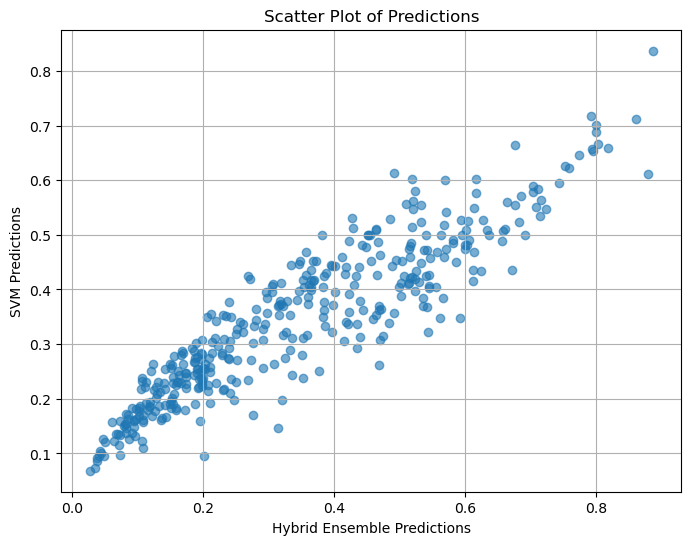

In [5]:
import pandas as pd

import matplotlib.pyplot as plt

# File paths
file1 = '/Users/lingyi/Documents/airr-ml/results/dataset_8_ESM_kmer/submission_hybrid_ensemble_esm2_t30_150M_8_vs_8_1_1216.csv'
file2 = '/Users/lingyi/Documents/airr-ml/results/dataset_8/predictions_SVM_Linear_esm2_t30_150M_train8_test8_1_max_mean.csv'

# Read the CSV files
df1 = pd.read_csv(file1)
df2 = pd.read_csv(file2)

# Merge the dataframes on the 'ID' column
merged_df = pd.merge(df1, df2, on='ID', suffixes=('_hybrid', '_svm'))

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(merged_df['Predicted_Prob_hybrid'], merged_df['Predicted_Prob_svm'], alpha=0.6)
plt.title('Scatter Plot of Predictions')
plt.xlabel('Hybrid Ensemble Predictions')
plt.ylabel('SVM Predictions')
plt.grid(True)
plt.show()

In [6]:
import os
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
import warnings

# Suppress convergence warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ==============================================================================
# CONFIGURATION
# ==============================================================================
KMER_PATH = "/Users/lingyi/Documents/airr-ml/data/kmer/k3_k4_train_dataset_8_features.pkl"
N_FOLDS = 5
SEED = 42
JOBS = -1  # Use all CPU cores

def load_kmer_data_robust():
    """Loads K-mers, handling the label mismatch issue automatically."""
    print(f"Loading K-mer data from {KMER_PATH}...")
    with open(KMER_PATH, "rb") as f:
        data = pickle.load(f)
    
    df_kmer = data[0]
    y_raw = data[1]
    
    # 1. Handle Labels (Find the numeric column)
    if hasattr(y_raw, "values"):
        y_temp = y_raw.values
    else:
        y_temp = np.array(y_raw)
        
    if y_temp.ndim == 2:
        # Heuristic: The column with 0s and 1s is the label
        for i in range(y_temp.shape[1]):
            col = y_temp[:, i]
            # Check if values are mostly 0 or 1
            unique_vals = np.unique(col)
            if len(unique_vals) <= 2 and all(v in [0, 1] for v in unique_vals):
                y = col.astype(float)
                print(f"✅ Found labels in column {i}")
                break
    else:
        y = y_temp.astype(float)

    # 2. Filter for 4-mers only
    k4_cols = [c for c in df_kmer.columns if c.startswith('k4__')]
    print(f"   Filtering {len(df_kmer.columns)} features -> {len(k4_cols)} 4-mers")
    X = df_kmer[k4_cols].values.astype(np.float32)
    
    # 3. Normalize (Row Frequency)
    row_sums = X.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1.0
    X = X / row_sums
    
    return X, y

def run_optimized_kmer_benchmark():
    X, y = load_kmer_data_robust()
    
    print("\n--- Starting Optimized LogisticRegressionCV (Lasso) ---")
    print("    Note: Using ALL features (no pre-filtering). This allows the model")
    print("    to find RARE signals that variance filtering might miss.")
    
    # Stratified CV
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
    
    fold_aucs = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Scale Data (StandardScaler is tricky with sparse data, 
        # but MaxAbsScaler is better for sparse frequencies)
        # However, for dense numpy arrays, we can just pass them if they are small enough
        # Or use simple scaling.
        
        # Train Logic: LogisticRegressionCV automates "C" selection
        # Cs=10 means it tries 10 different regularization strengths (1e-4 to 1e4)
        model = LogisticRegressionCV(
            Cs=10, 
            penalty='l1', 
            solver='liblinear', # Liblinear is good for high-dim sparse data
            cv=3,               # Inner CV to find best C
            scoring='roc_auc',
            max_iter=1000,
            n_jobs=JOBS,
            random_state=SEED
        )
        
        print(f"Training Fold {fold}...")
        model.fit(X_train, y_train)
        
        # Evaluate
        probs = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, probs)
        
        print(f"  Fold {fold}: AUC = {auc:.4f} (Best C: {model.C_[0]:.2e})")
        fold_aucs.append(auc)
        
    mean_auc = np.mean(fold_aucs)
    print("-" * 40)
    print(f"Optimized K-mer Mean AUC: {mean_auc:.4f}")
    print("-" * 40)
    
    if mean_auc > 0.72:
        print("✅ SUCCESS: K-mer model is now strong enough to ensemble.")
    else:
        print("❌ FAILURE: K-mer signal is inherently weak for this dataset encoding.")

if __name__ == "__main__":
    run_optimized_kmer_benchmark()

Loading K-mer data from /Users/lingyi/Documents/airr-ml/data/kmer/k3_k4_train_dataset_8_features.pkl...
✅ Found labels in column 1
   Filtering 165711 features -> 157711 4-mers

--- Starting Optimized LogisticRegressionCV (Lasso) ---
    Note: Using ALL features (no pre-filtering). This allows the model
    to find RARE signals that variance filtering might miss.
Training Fold 1...
  Fold 1: AUC = 0.7954 (Best C: 1.29e+03)
Training Fold 2...
  Fold 2: AUC = 0.7770 (Best C: 1.29e+03)
Training Fold 3...
  Fold 3: AUC = 0.7275 (Best C: 1.29e+03)
Training Fold 4...
  Fold 4: AUC = 0.7408 (Best C: 1.29e+03)
Training Fold 5...
  Fold 5: AUC = 0.7744 (Best C: 1.29e+03)
----------------------------------------
Optimized K-mer Mean AUC: 0.7630
----------------------------------------
✅ SUCCESS: K-mer model is now strong enough to ensemble.


In [ ]:
with open('/Users/lingyi/Documents/airr-ml/data/kmer/k3_k4_train_dataset_8_features.pkl', 'rb') as file:
    data = pickle.load(file)

# Inspect the loaded data
print(type(data))
print(data)


# Select columns that start with 'k4__'


<class 'tuple'>
(                                  k3__CAA  k3__AAA  k3__AAG  k3__AGE  k3__GED  \
ID                                                                              
e441182799ba6725d4ae80e218ce3116      176      145      863     2213      238   
61908a66e4139b675d0435bf1a16cff0      141       97      644     1653      167   
a532d971f2210ec540f3c4213dc939c3      120       84      535     1460      125   
f9796a66e1aececaedec1ec79af32c52      143      143      797     1806      262   
d000f7c2ffa2a76540c01a59537a8a19       74       65      423     1099      121   
...                                   ...      ...      ...      ...      ...   
14e675561973f44be8cddaf42efcf9b0       79       62      433     1175      138   
3aaa1f17bfeff7f99e337f67fe5f37d1       50       42      315      726       84   
40589bb528d2f8181d31bff090714df7       77       89      460     1362      156   
5baa4fa84b30b57284b2f80973e58228      138      118      698     1916      232   
d73b93a3bfb

,k3__CAA,k3__AAA,k3__AAG,k3__AGE,k3__GED,k3__EDG,k3__DGY,k3__GYT,k3__YTF,k3__AGG,...,k4__QHHC,k4__MAEC,k4__YKLC,k4__MPCF,k4__CNDM,k4__VAHC,k4__CWNF,k4__FCHK,k4__CCEF,k4__TCNW
ID,,,,,,,,,,,,,,,,,,,,,
e441182799ba6725d4ae80e218ce3116,176,145,863,2213,238,156,1157,15413,15301,5563,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61908a66e4139b675d0435bf1a16cff0,141,97,644,1653,167,100,792,11515,11376,4432,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a532d971f2210ec540f3c4213dc939c3,120,84,535,1460,125,78,593,8084,8034,3556,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
f9796a66e1aececaedec1ec79af32c52,143,143,797,1806,262,163,1143,17051,16948,4499,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
d000f7c2ffa2a76540c01a59537a8a19,74,65,423,1099,121,65,543,8066,7983,2599,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14e675561973f44be8cddaf42efcf9b0,79,62,433,1175,138,85,467,7211,7124,3021,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3aaa1f17bfeff7f99e337f67fe5f37d1,50,42,315,726,84,50,354,4977,4968,1851,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
40589bb528d2f8181d31bff090714df7,77,89,460,1362,156,93,698,10146,10064,3243,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
